<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/4_Feature_selection_%26_data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
org = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo/new_dataset.csv')

df = org.copy()
df.dropna(inplace = True)
df["date"] = pd.to_datetime(df["date"])
df.insert(0,'new_date',pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
df.drop(['date'], axis=1, inplace=True)

for col in df.columns:
  df[col] = pd.to_numeric(df[col],errors = 'coerce')
  df[col] =df[col].apply(lambda x: round(x, 3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


## **Approach 1**:  Feature selection -> data balacing

In [ ]:
#https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

X = df.drop(['duration', 'new_date'], axis=1)
y = df['duration']

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 1000)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Lasso (l1) penalty.
# The selectFromModel class from sklearn, which  will select the features which coefficients are non-zero
selector = SelectFromModel(linear_model.Lasso(alpha=0.00))
selector.fit(X, y)

selected_feat = X.columns[(selector.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(selector.estimator_.coef_) > np.abs(
                selector.estimator_.coef_).mean())))

In [ ]:
fs_db_lasso_df = df[selected_feat]
fs_db_lasso_df[['duration', 'date']] = org[[ 'duration', 'date' ]]

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

fs_db_lasso_df["date"] = pd.to_datetime(fs_db_lasso_df["date"])
fs_db_lasso_df.insert(0,'new_date',pd.to_datetime(fs_db_lasso_df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
fs_db_lasso_df.drop(['date'], axis=1, inplace=True)

X = fs_db_lasso_df.drop(['label'], axis=1)
y = fs_db_lasso_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))

X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'label',y_train)

X_train_smote_tl_res.insert(0,'dates',pd.to_datetime(X_train_smote_tl_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_tl_res.drop('new_date', axis=1, inplace=True)
X_train_smote_tl_res.insert(len(X_train_smote_tl_res.columns),'label',y_train_smote_tl_res)

fs_db_final = X_train.append(X_train_smote_tl_res, ignore_index=True)
fs_db_final = fs_db_final.sort_values(by="dates")

## **Approach 2**: Data balacing -> Feature selection 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X = df.drop(['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))
X_train_smote_tl_res.shape, y_train_smote_tl_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 29692
Before: counts of label '0': 229 

After smote-tl: counts of label '1': 25908
After smote-tl: counts of label '0': 25908


((51816, 15), (51816,), (12824, 15), (12824,))

In [ ]:
X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'label',y_train)

X_train_smote_tl_res.insert(0,'dates',pd.to_datetime(X_train_smote_tl_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_tl_res.drop('new_date', axis=1, inplace=True)
X_train_smote_tl_res.insert(len(X_train_smote_tl_res.columns),'label',y_train_smote_tl_res)

smote_tl_db = X_train.append(X_train_smote_tl_res, ignore_index=True)
smote_tl_db = smote_tl_db.sort_values(by="dates")

In [ ]:
#https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

X = smote_tl_db.drop(['duration', 'label', 'dates'], axis=1)
y = smote_tl_db['duration']

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 1000)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Lasso (l1) penalty.
# The selectFromModel class from sklearn, which  will select the features which coefficients are non-zero
selector = SelectFromModel(linear_model.Lasso(alpha=0.000))
selector.fit(X, y)

selected_feat = X.columns[(selector.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(selector.estimator_.coef_) > np.abs(
                selector.estimator_.coef_).mean())))

In [ ]:
db_fs_final = df[selected_feat]
db_fs_final[['duration','label', 'dates']] = smote_tl_db[[ 'duration', 'label', 'dates' ]]

In [ ]:
all_dfs = [fs_db_final, db_fs_final]

Accuracy:  0 99.94611013129531
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6543
           1       1.00      1.00      1.00     13869

    accuracy                           1.00     20412
   macro avg       1.00      1.00      1.00     20412
weighted avg       1.00      1.00      1.00     20412

ROC_AUC_SCORE  0.9998871396219027
_______________________________________________ 

Accuracy:  1 99.56957050622252
              precision    recall  f1-score   support

           0       0.81      0.62      0.71        88
           1       1.00      1.00      1.00     10599

    accuracy                           1.00     10687
   macro avg       0.90      0.81      0.85     10687
weighted avg       1.00      1.00      1.00     10687

ROC_AUC_SCORE  0.862208270076937
_______________________________________________ 



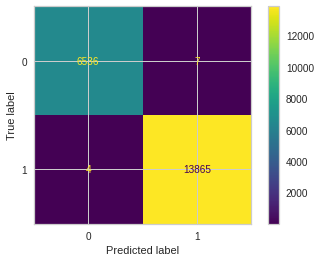

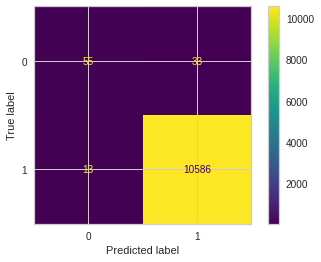

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
model = 0
i = 0

for df in all_dfs:
  X = df.drop(['label', 'dates'], axis=1)
  y = df['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100


  print('Accuracy: ',i,test_accuracy)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test)

  print(classification_report(y_test,y_pred))

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('ROC_AUC_SCORE ',roc_auc_score(y_test,y_pred_proba))
  print('_______________________________________________ \n')
  i = i + 1

✅ Conclusion: Best approach is Feature selection then data balacing <br>
Accuracy: 99.94% <br>
ROC_AUC score: 0.9998

In [ ]:
fs_db_final.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv', index=False)
fs_db_final

,dates,temps_cycle,temps_dosage,temps_injection,pression_com,volume_com,matelas,val_pointe,integral,pression,volume,duration,label
13928,2022-01-02 17:43:00.000000000,23.770000,0.000000,3.570000,902,16.5,14.170000,1056,82,1958,30.670000,27.340000,0
42096,2022-01-02 17:43:00.000000000,23.770000,0.000000,3.570000,902,16.5,14.170000,1056,82,1958,30.670000,27.340000,0
59403,2022-01-02 17:43:00.555529728,23.769959,0.000000,3.569997,901,16.5,14.169156,1056,82,1957,30.669156,27.339955,0
62127,2022-01-02 17:43:05.041107200,23.769627,0.000000,3.569969,901,16.5,14.162345,1056,82,1957,30.662345,27.339595,0
60775,2022-01-02 17:43:18.795806976,23.768608,0.000000,3.569884,901,16.5,14.141458,1056,82,1957,30.641458,27.338492,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62976,2022-12-02 16:34:11.356482048,26.668933,3.734217,3.540000,1342,16.5,15.983710,1374,126,2716,32.483710,33.943151,0
458,2022-12-02 16:40:00.000000000,26.920000,4.250000,3.530000,1342,16.5,16.260000,1361,129,2703,32.760000,34.700000,1
56091,2022-12-02 16:42:42.406099456,26.919998,4.049956,3.539992,1385,16.5,16.280008,1400,132,2786,32.780008,34.509946,0
41955,2022-12-02 16:43:00.000000000,26.920000,4.050000,3.540000,1386,16.5,16.280000,1401,132,2787,32.780000,34.510000,0
